In [3]:
# Thêm thư viện
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import string
import os
from PIL import Image
import glob
from pickle import dump, load
from time import time

import torch
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter("logs")

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [6]:
# Đọc file các caption
def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text

filename = "/content/drive/MyDrive/Practical Deep Learning/Lesson 11: Thực hành/Flickr8k/Flickr8k_text/Flickr8k.token.txt"

doc = load_doc(filename)
print(doc[:300])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the s


In [7]:
# Lưu caption dưới dạng key value: id_image : ['caption 1', 'caption 2', 'caption 3',' caption 4', 'caption 5']
def load_descriptions(doc):
	mapping = dict()
	# process lines
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		if len(line) < 2:
			continue
		# take the first token as the image id, the rest as the description
		image_id, image_desc = tokens[0], tokens[1:]
		# extract filename from image id
		image_id = image_id.split('.')[0]
		# convert description tokens back to string
		image_desc = ' '.join(image_desc)
		# create the list if needed
		if image_id not in mapping:
			mapping[image_id] = list()
		# store description
		mapping[image_id].append(image_desc)
	return mapping

descriptions = load_descriptions(doc)
print('Loaded: %d ' % len(descriptions))

Loaded: 8092 


In [8]:
descriptions['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [9]:
# Preprocessing text
def clean_descriptions(descriptions):
	# prepare translation table for removing punctuation
	table = str.maketrans('', '', string.punctuation)
	for key, desc_list in descriptions.items():
		for i in range(len(desc_list)):
			desc = desc_list[i]
			# tokenize
			desc = desc.split()
			# convert to lower case
			desc = [word.lower() for word in desc]
			# remove punctuation from each token
			desc = [w.translate(table) for w in desc]
			# remove hanging 's' and 'a'
			desc = [word for word in desc if len(word)>1]
			# remove tokens with numbers in them
			desc = [word for word in desc if word.isalpha()]
			# store as string
			desc_list[i] =  ' '.join(desc)

# clean descriptions
clean_descriptions(descriptions)

In [10]:
descriptions['1000268201_693b08cb0e']

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [11]:
# Lưu description xuống file
def save_descriptions(descriptions, filename):
	lines = list()
	for key, desc_list in descriptions.items():
		for desc in desc_list:
			lines.append(key + ' ' + desc)
	data = '\n'.join(lines)
	file = open(filename, 'w')
	file.write(data)
	file.close()

save_descriptions(descriptions, 'descriptions.txt')

In [12]:
# Lấy id ảnh tương ứng với dữ liệu train, test, dev
def load_set(filename):
	doc = load_doc(filename)
	dataset = list()
	# process line by line
	for line in doc.split('\n'):
		# skip empty lines
		if len(line) < 1:
			continue
		# get the image identifier
		identifier = line.split('.')[0]
		dataset.append(identifier)
	return set(dataset)

# load training dataset (6K)
filename = '/content/drive/MyDrive/Practical Deep Learning/Lesson 11: Thực hành/Flickr8k/Flickr8k_text/Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))

Dataset: 6000


In [13]:
# Folder chứa dữ ảnh
images = '/content/drive/MyDrive/Practical Deep Learning/Lesson 11: Thực hành/Flickr8k/Flickr8k_Dataset/Flicker8k_Dataset/'
# Lấy lấy các ảnh jpg trong thư mục
img = glob.glob(images + '*.jpg')
img[0]

'/content/drive/MyDrive/Practical Deep Learning/Lesson 11: Thực hành/Flickr8k/Flickr8k_Dataset/Flicker8k_Dataset/2116316160_d5fa7abdc3.jpg'

In [14]:
# File chứa các id ảnh để train
train_images_file = '/content/drive/MyDrive/Practical Deep Learning/Lesson 11: Thực hành/Flickr8k/Flickr8k_text/Flickr_8k.trainImages.txt'
# Read the train image names in a set
train_images = set(open(train_images_file, 'r').read().strip().split('\n'))

# Create a list of all the training images with their full path names
train_img = []

for i in img: # img is list of full path names of all images
    if i[len(images):] in train_images: # Check if the image belongs to training set
        train_img.append(i) # Add it to the list of train images

In [15]:
# File chứa các id ảnh để test
test_images_file = '/content/drive/MyDrive/Practical Deep Learning/Lesson 11: Thực hành/Flickr8k/Flickr8k_text/Flickr_8k.testImages.txt'
# Read the validation image names in a set# Read the test image names in a set
test_images = set(open(test_images_file, 'r').read().strip().split('\n'))

# Create a list of all the test images with their full path names
test_img = []

for i in img: # img is list of full path names of all images
    if i[len(images):] in test_images: # Check if the image belongs to test set
        test_img.append(i) # Add it to the list of test images

In [16]:
# Thêm 'startseq', 'endseq' cho chuỗi
def load_clean_descriptions(filename, dataset):
	# load document
	doc = load_doc(filename)
	descriptions = dict()
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		# split id from description
		image_id, image_desc = tokens[0], tokens[1:]
		# skip images not in the set
		if image_id in dataset:
			# create list
			if image_id not in descriptions:
				descriptions[image_id] = list()
			# wrap description in tokens
			desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
			# store
			descriptions[image_id].append(desc)
	return descriptions

# descriptions
train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))

Descriptions: train=6000


In [17]:
import torch
from torchvision import models, transforms
from PIL import Image

# Step 1: Load the ResNet50 model
resnet50 = models.resnet50(pretrained=True)
print(resnet50)
# Step 2: Modify the model to output embeddings
# Remove the final classification layer
model = torch.nn.Sequential(*list(resnet50.children())[:-1]).to(device=device)
model.eval()

# Step 3: Define the image preprocessing steps
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Step 4: Load and preprocess the image
def load_image(image_path):
    image = Image.open(image_path).convert("RGB")
    image = preprocess(image)
    image = image.unsqueeze(0)  # Add batch dimension
    return image

# Step 5: Get the image embedding vector
def get_embedding(image_path):
    image = load_image(image_path)
    with torch.no_grad():
        image = image.to(device)
        embedding = model(image)
    embedding = embedding.squeeze()  # Remove batch dimension
    return embedding.detach().to("cpu").numpy()


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:05<00:00, 18.6MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [18]:
# Gọi hàm encode với các ảnh trong traning set
start = time()
encoding_train = {}
for img in train_img:
    encoding_train[img[len(images):]] = get_embedding(img)
print("Time taken in seconds =", time()-start)

Time taken in seconds = 318.1038165092468


In [19]:
# Lưu image embedding lại
save_pickle_dir = "/content/drive/MyDrive/Practical Deep Learning/Lesson 11: Thực hành/Flickr8k/Pickle/"
os.makedirs(save_pickle_dir, exist_ok=True)
with open(os.path.join(save_pickle_dir, "encoded_train_images.pkl"), "wb") as encoded_pickle:
    dump(encoding_train, encoded_pickle)

In [20]:
# Encode test image
start = time()
encoding_test = {}
for img in test_img:
    encoding_test[img[len(images):]] = get_embedding(img)
print("Time taken in seconds =", time()-start)

Time taken in seconds = 17.633054494857788


In [21]:
# Lưu image embedding lại
save_pickle_dir = "/content/drive/MyDrive/Practical Deep Learning/Lesson 11: Thực hành/Flickr8k/Pickle/"
os.makedirs(save_pickle_dir, exist_ok=True)
with open(os.path.join(save_pickle_dir, "encoded_test_images.pkl"), "wb") as encoded_pickle:
    dump(encoding_test, encoded_pickle)

In [22]:
train_features = load(open("/content/drive/MyDrive/Practical Deep Learning/Lesson 11: Thực hành/Flickr8k/Pickle/encoded_train_images.pkl", "rb"))
print('Photos: train=%d' % len(train_features))

Photos: train=6000


In [23]:
train_features.keys()

dict_keys(['2116316160_d5fa7abdc3.jpg', '2095007523_591f255708.jpg', '2046778775_0dd7cac6ab.jpg', '2052702658_da1204f6d1.jpg', '2095478050_736c4d2d28.jpg', '2086532897_b8714f2237.jpg', '191003287_2915c11d8e.jpg', '2159447283_fab8c272b0.jpg', '2102732029_9ae520914d.jpg', '1937262236_cbf5bfa101.jpg', '2029280005_a19609c81a.jpg', '2090386465_b6ebb7df2c.jpg', '2062607137_dac194ad02.jpg', '2101128963_fdf8b2a0d7.jpg', '190965502_0b9ed331d9.jpg', '2042009399_afad34e7c1.jpg', '2169951750_495820a215.jpg', '2070831281_dc04b3e15d.jpg', '2098646162_e3b3bbf14c.jpg', '2095435987_1b7591d214.jpg', '2149968397_a7411729d1.jpg', '2085400856_ae09df33a7.jpg', '1917203130_fcaff8b10e.jpg', '2183967273_d182e18cf6.jpg', '2144846312_d4c738dc6c.jpg', '2144049642_070cf541b4.jpg', '207930963_af3a2f1784.jpg', '1859941832_7faf6e5fa9.jpg', '1957371533_62bc720bac.jpg', '2109479807_eec8d72ca7.jpg', '186890605_ddff5b694e.jpg', '216172386_9ac5356dae.jpg', '2186367337_0ce9ce2104.jpg', '2216568822_84c295c3b0.jpg', '2251447

In [24]:
# Tạo list các training caption
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)
len(all_train_captions)

30000

In [25]:
# Chỉ lấy các từ xuất hiện trên 10 lần
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d -> %d' % (len(word_counts), len(vocab)))

preprocessed words 7578 -> 1651


In [26]:
ixtoword = {}
wordtoix = {}

ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1


In [27]:
vocab_size = len(ixtoword) + 1 # Thêm 1 cho từ dùng để padding
vocab_size

1652

In [28]:
# convert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
	all_desc = list()
	for key in descriptions.keys():
		[all_desc.append(d) for d in descriptions[key]]
	return all_desc

# calculate the length of the description with the most words
def max_length(descriptions):
	lines = to_lines(descriptions)
	return max(len(d.split()) for d in lines)

# determine the maximum sequence length
max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)

Description Length: 34


In [29]:
# Load Glove model
glove_dir = '/content/drive/MyDrive/Practical Deep Learning/Lesson 11: Thực hành/glove.6B'
embeddings_index = {} # empty dictionary
f = open(os.path.join(glove_dir, 'glove.6B.200d.txt'), encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400001 word vectors.


In [30]:
embeddings_index['the']

array([-7.1549e-02,  9.3459e-02,  2.3738e-02, -9.0339e-02,  5.6123e-02,
        3.2547e-01, -3.9796e-01, -9.2139e-02,  6.1181e-02, -1.8950e-01,
        1.3061e-01,  1.4349e-01,  1.1479e-02,  3.8158e-01,  5.4030e-01,
       -1.4088e-01,  2.4315e-01,  2.3036e-01, -5.5339e-01,  4.8154e-02,
        4.5662e-01,  3.2338e+00,  2.0199e-02,  4.9019e-02, -1.4132e-02,
        7.6017e-02, -1.1527e-01,  2.0060e-01, -7.7657e-02,  2.4328e-01,
        1.6368e-01, -3.4118e-01, -6.6070e-02,  1.0152e-01,  3.8232e-02,
       -1.7668e-01, -8.8153e-01, -3.3895e-01, -3.5481e-02, -5.5095e-01,
       -1.6899e-02, -4.3982e-01,  3.9004e-02,  4.0447e-01, -2.5880e-01,
        6.4594e-01,  2.6641e-01,  2.8009e-01, -2.4625e-02,  6.3302e-01,
       -3.1700e-01,  1.0271e-01,  3.0886e-01,  9.7792e-02, -3.8227e-01,
        8.6552e-02,  4.7075e-02,  2.3511e-01, -3.2127e-01, -2.8538e-01,
        1.6670e-01, -4.9707e-03, -6.2714e-01, -2.4904e-01,  2.9713e-01,
        1.4379e-01, -1.2325e-01, -5.8178e-02, -1.0290e-03, -8.21

In [31]:
embedding_dim = 200

# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoix.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

In [32]:
embedding_matrix.shape

(1652, 200)

In [33]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torch.optim as optim

In [34]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MyModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, max_length):
        super(MyModel, self).__init__()
        self.fe1_dropout = nn.Dropout(0.5)
        self.fe2_dense = nn.Linear(2048, 256)

        self.se1_embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.se2_dropout = nn.Dropout(0.5)
        self.se3_lstm = nn.LSTM(embedding_dim, 256, batch_first=True)

        self.decoder1_dense = nn.Linear(256, 256)
        self.decoder2_dense = nn.Linear(256, vocab_size)

    def forward(self, inputs1, inputs2):
        # Feature extractor part
        fe1 = self.fe1_dropout(inputs1)
        fe2 = F.relu(self.fe2_dense(fe1))

        # Sequence encoder part
        se1 = self.se1_embedding(inputs2)
        se2 = self.se2_dropout(se1)
        _, (se3, _) = self.se3_lstm(se2)
        se3 = se3[-1]  # Get the last hidden state

        # Decoder part
        decoder1 = fe2 + se3
        decoder2 = F.relu(self.decoder1_dense(decoder1))
        outputs = F.log_softmax(self.decoder2_dense(decoder2), dim=-1)

        return outputs

In [35]:
embedding_matrix = torch.tensor(embedding_matrix, dtype=torch.float32)
embedding_layer = nn.Embedding.from_pretrained(embedding_matrix)

In [36]:
model = MyModel(vocab_size, embedding_dim, max_length)

In [37]:
# Replace the embedding layer with the GloVe embeddings
model.embedding = embedding_layer

In [38]:
model

MyModel(
  (fe1_dropout): Dropout(p=0.5, inplace=False)
  (fe2_dense): Linear(in_features=2048, out_features=256, bias=True)
  (se1_embedding): Embedding(1652, 200, padding_idx=0)
  (se2_dropout): Dropout(p=0.5, inplace=False)
  (se3_lstm): LSTM(200, 256, batch_first=True)
  (decoder1_dense): Linear(in_features=256, out_features=256, bias=True)
  (decoder2_dense): Linear(in_features=256, out_features=1652, bias=True)
  (embedding): Embedding(1652, 200)
)

In [39]:
# Freeze embedding layer
for param in model.embedding.parameters():
    param.requires_grad = False

In [40]:
class CaptionDataset(Dataset):
    def __init__(self, descriptions, photos, wordtoix, max_length, vocab_size):
        self.descriptions = descriptions
        self.photos = photos
        self.wordtoix = wordtoix
        self.max_length = max_length
        self.vocab_size = vocab_size
        self.X1, self.X2, self.y = self._create_dataset()

    def _create_dataset(self):
        X1, X2, y = [], [], []
        for key, desc_list in self.descriptions.items():
            # retrieve the photo feature
            photo = self.photos[key + '.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [self.wordtoix[word] for word in desc.split(' ') if word in self.wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = self._pad_sequence(in_seq, self.max_length)
                    # encode output sequence
                    # out_seq = self._one_hot_encode(out_seq, self.vocab_size)
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
        return X1, X2, y

    def _pad_sequence(self, seq, max_length):
        seq = torch.tensor(seq, dtype=torch.long)
        padded_seq = torch.zeros(max_length, dtype=torch.long)
        padded_seq[-len(seq):] = seq  # pad sequences with zeros at the start
        return padded_seq

    def _one_hot_encode(self, seq, vocab_size):
        seq = torch.tensor(seq, dtype=torch.long)
        one_hot_seq = F.one_hot(seq, num_classes=vocab_size)
        return one_hot_seq

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        img = torch.from_numpy(self.X1[idx])
        in_seq = self.X2[idx]
        output = torch.from_numpy(np.array([self.y[idx]]))
        return img, in_seq, output

# Create the dataset
dataset = CaptionDataset(train_descriptions, train_features, wordtoix, max_length, vocab_size)

# Create the DataLoader
data_loader = DataLoader(dataset, batch_size=512, shuffle=True)

# Iterate through batches
# for batch in data_loader:
#     X1_batch, X2_batch, y_batch = batch
#     print(X1_batch.shape, X2_batch.shape, y_batch.shape)

In [41]:
train_features, train_inseqs, train_labels = next(iter(data_loader))

In [42]:
out = model(train_features, train_inseqs)
out.shape

torch.Size([512, 1652])

In [43]:
# Initialize the loss function, and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [44]:
loss = criterion(out, train_labels.squeeze(1))
loss

tensor(7.4219, grad_fn=<NllLossBackward0>)

In [45]:
from tqdm import tqdm
def evaluate_model(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

    return test_loss / len(test_loader)

def train_model(model, train_loader, criterion, optimizer, num_epochs):
    losses = []
    model.train()
    num_iter = 0
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, in_seqs, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            in_seqs = in_seqs.to(device)
            optimizer.zero_grad()
            outputs = model(images, in_seqs)
            loss = criterion(outputs, labels.squeeze(1))
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            writer.add_scalar("Loss/train", loss.item(), epoch)
            num_iter += 1
            # if num_iter % 500 == 0:  # Print loss every 100 iterations
            #     print(f'Epoch [{epoch+1}/{num_epochs}], Iteration [{num_iter}/{len(train_loader)}], Loss: {running_loss/500:.4f}')
        num_iter = 0
        losses.append(running_loss / len(train_loader))
        model.eval()
        correct = 0
        total = 0
        model.train()
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')
    return losses


In [46]:
# Training the model
num_epochs = 20
model = model.to(device)
losses = train_model(model, data_loader, criterion, optimizer, num_epochs)
writer.flush()

Epoch [1/20], Loss: 5.1611
Epoch [2/20], Loss: 4.3346
Epoch [3/20], Loss: 3.9911
Epoch [4/20], Loss: 3.7983
Epoch [5/20], Loss: 3.6689
Epoch [6/20], Loss: 3.5685
Epoch [7/20], Loss: 3.4917
Epoch [8/20], Loss: 3.4271
Epoch [9/20], Loss: 3.3720
Epoch [10/20], Loss: 3.3235
Epoch [11/20], Loss: 3.2814
Epoch [12/20], Loss: 3.2413
Epoch [13/20], Loss: 3.2069
Epoch [14/20], Loss: 3.1762
Epoch [15/20], Loss: 3.1465
Epoch [16/20], Loss: 3.1188
Epoch [17/20], Loss: 3.0933
Epoch [18/20], Loss: 3.0699
Epoch [19/20], Loss: 3.0480
Epoch [20/20], Loss: 3.0280


In [47]:
torch.save(model.state_dict(), "checkpoint.pth")

In [48]:
model.eval()

MyModel(
  (fe1_dropout): Dropout(p=0.5, inplace=False)
  (fe2_dense): Linear(in_features=2048, out_features=256, bias=True)
  (se1_embedding): Embedding(1652, 200, padding_idx=0)
  (se2_dropout): Dropout(p=0.5, inplace=False)
  (se3_lstm): LSTM(200, 256, batch_first=True)
  (decoder1_dense): Linear(in_features=256, out_features=256, bias=True)
  (decoder2_dense): Linear(in_features=256, out_features=1652, bias=True)
  (embedding): Embedding(1652, 200)
)

In [49]:
def pad_sequences(seq, max_length):
    seq = torch.tensor(seq, dtype=torch.long)
    padded_seq = torch.zeros(max_length, dtype=torch.long)
    padded_seq[-len(seq):] = seq  # pad sequences with zeros at the start
    return padded_seq

In [50]:
# Với môi ảnh mới khi test, ta sẽ bắt đầu chuỗi với 'startseq' rồi sau đó cho vào model để dự đoán từ tiếp theo. Ta thêm từ
# vừa được dự đoán vào chuỗi và tiếp tục cho đến khi gặp 'endseq' là kết thúc hoặc cho đến khi chuỗi dài 34 từ.
def greedySearch(photo, max_length):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences(sequence, max_length=max_length)
        photo = photo.unsqueeze(0).to(device)
        sequence = sequence.unsqueeze(0).to(device)
        yhat = model(photo,sequence)
        yhat = np.argmax(yhat.cpu().detach().numpy())
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

In [51]:
encoding_test = load(open("/content/drive/MyDrive/Practical Deep Learning/Lesson 11: Thực hành/Flickr8k/Pickle/encoded_test_images.pkl", "rb"))
print('Photos: test=%d' % len(encoding_test))

Photos: test=1000


In [52]:
images = "/content/drive/MyDrive/Practical Deep Learning/Lesson 11: Thực hành/Flickr8k/Flickr8k_Dataset/Flicker8k_Dataset"

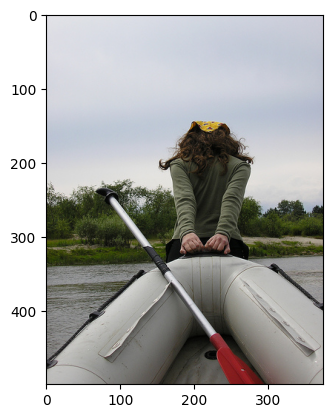

boat is rowing on the beach


In [53]:
z=8
pic = list(encoding_test.keys())[z]
image = encoding_test[pic]
image = torch.from_numpy(image)
x=plt.imread(os.path.join(images, str(pic)))
plt.imshow(x)
plt.show()
print(greedySearch(image, max_length))